In [1]:
import os 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchinfo  

from trainer import Trainer 
from tester import Tester
from utils import  visualize_data,show_misclassified_images,plot_class_distribution,plot_confusion_matrix,plot_curves,denormalize
from dataloader import Cifar10DataLoader,Cifar10Dataset
from vistransformers import train_transforms,test_transforms
from model import Network

/home/muthu/miniconda3/envs/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/muthu/ASUS/AIDSML/DLLessons/VISION DL/Ch9/vistransformers.py:33: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(
/home/muthu/miniconda3/envs/venv/lib/python3.12/site-packages/albumentations/core/validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/home/muthu/ASUS/AIDSML/DLLessons/VISION DL/Ch9/vistransformers.py:64: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(
/home/muthu/ASUS/AIDSML/DLLessons/VISION DL/Ch9/vistransformers.py:69: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value, mask_fill_val

In [2]:
torch.cuda.amp.autocast(enabled=True,dtype=torch.float16)
torch.set_float32_matmul_precision('medium')

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Is CUDA available? ", use_cuda)

Is CUDA available?  True


/tmp/ipykernel_268134/2874717501.py:1: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  torch.cuda.amp.autocast(enabled=True,dtype=torch.float16)


In [3]:
DATAPATH:str = os.path.join(os.environ["HOME"],"Documents","Data")

In [4]:
# CIFAR10 Data
train_data = Cifar10Dataset(root=DATAPATH,train=True,download=False,transform=train_transforms)
test_data = Cifar10Dataset(root=DATAPATH,train=False,download=False,transform=test_transforms)

# CIFAR10 DataLoader
loader = Cifar10DataLoader(batch_size=32,is_cuda_available=True)
train_loader = loader.get_loader(train_data,train=True)
test_loader  = loader.get_loader(test_data,train=False)

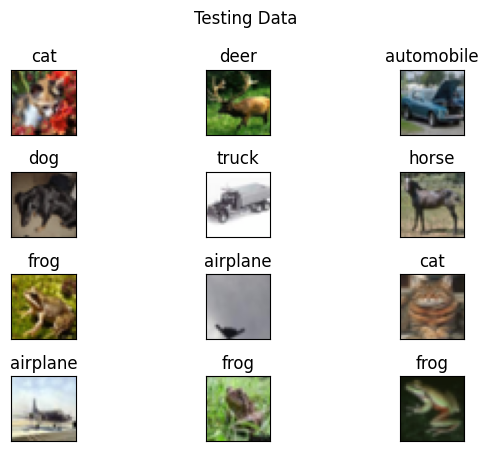

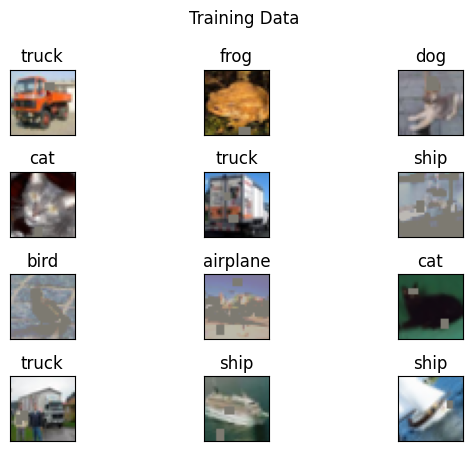

In [5]:
visualize_data(test_loader,12,"Testing Data",classes=test_data.classes);
visualize_data(train_loader,12,"Training Data",classes=train_data.classes);

In [6]:
model  = Network().to(device=device)
torchinfo.summary(model=model.cuda(),input_data=torch.ones((12,3,32,32),device="cuda"))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [12, 10]                  --
├─Sequential: 1-1                        [12, 8, 32, 32]           --
│    └─Conv2d: 2-1                       [12, 8, 32, 32]           216
│    └─ReLU: 2-2                         [12, 8, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [12, 8, 32, 32]           16
│    └─Dropout2d: 2-4                    [12, 8, 32, 32]           --
├─Sequential: 1-2                        [12, 16, 32, 32]          --
│    └─Conv2d: 2-5                       [12, 16, 32, 32]          1,152
│    └─ReLU: 2-6                         [12, 16, 32, 32]          --
│    └─BatchNorm2d: 2-7                  [12, 16, 32, 32]          32
│    └─Dropout2d: 2-8                    [12, 16, 32, 32]          --
├─Sequential: 1-3                        [12, 16, 32, 32]          --
│    └─Conv2d: 2-9                       [12, 16, 32, 32]          2,304
│    └─R

 65%|██████▌   | 65/100 [00:00<00:00, 116.75it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.48E-01


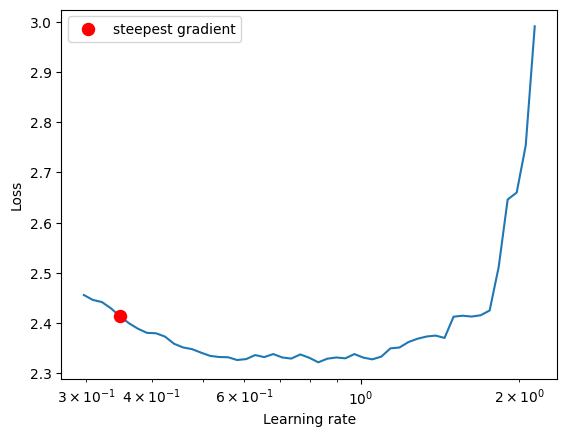

In [7]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)

lr_finder = LRFinder(model,optimizer,criterion,device=device)
lr_finder.range_test(train_loader,end_lr=10,num_iter=100,step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [8]:
EPOCH  = 50
current_accuracy = 80.27  # Target

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=7.97E-01, 
                                          pct_start=5/EPOCH,
                                          anneal_strategy='linear',
                                          cycle_momentum=True,
                                          base_momentum=0.85,
                                          max_momentum=0.95,
                                          steps_per_epoch=len(train_loader),
                                          epochs= EPOCH,
                                          three_phase=False,
                                          div_factor=100,
                                          final_div_factor=100
            )



trainer = Trainer(model, train_loader, optimizer, criterion, device)
tester = Tester(model, test_loader, criterion, device)


for epoch in range(0, EPOCH):
    trainer.train(epoch=epoch)
    test_acc,test_loss = tester.test()
    scheduler.step()
    if test_acc>current_accuracy:
        current_accuracy = test_acc
        # Model Save
        torch.save({
                        'model': model.state_dict(),
                        'optimizer':optimizer.state_dict(),
                        'scheduler':scheduler.state_dict(),
                        'epoch': epoch
                    },
                    "./data/modelcifar10_{}.pth".format(test_acc)
        )
    print('-'*150)

EPOCH=0| LR=0.007970| LOSS=1.55| BATCH=1562| ACCURACY=33.776: 100%|██████████| 1563/1563 [00:11<00:00, 139.17it/s]
LOSS=461.13| BATCH=312| ACCURACY=45.490: 100%|██████████| 313/313 [00:00<00:00, 317.10it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=1| LR=0.008071| LOSS=1.66| BATCH=1562| ACCURACY=42.014: 100%|██████████| 1563/1563 [00:11<00:00, 140.40it/s]
LOSS=406.30| BATCH=312| ACCURACY=51.710: 100%|██████████| 313/313 [00:00<00:00, 323.16it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=2| LR=0.008172| LOSS=1.53| BATCH=1562| ACCURACY=47.168: 100%|██████████| 1563/1563 [00:11<00:00, 139.16it/s]
LOSS=360.81| BATCH=312| ACCURACY=59.310: 100%|██████████| 313/313 [00:01<00:00, 311.94it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=3| LR=0.008273| LOSS=1.54| BATCH=1562| ACCURACY=51.102: 100%|██████████| 1563/1563 [00:11<00:00, 137.66it/s]
LOSS=318.70| BATCH=312| ACCURACY=64.450: 100%|██████████| 313/313 [00:00<00:00, 318.02it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=4| LR=0.008374| LOSS=1.39| BATCH=1562| ACCURACY=53.990: 100%|██████████| 1563/1563 [00:11<00:00, 137.78it/s]
LOSS=303.30| BATCH=312| ACCURACY=65.820: 100%|██████████| 313/313 [00:00<00:00, 314.36it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=5| LR=0.008475| LOSS=1.22| BATCH=1562| ACCURACY=56.038: 100%|██████████| 1563/1563 [00:11<00:00, 139.48it/s]
LOSS=281.80| BATCH=312| ACCURACY=68.800: 100%|██████████| 313/313 [00:01<00:00, 303.09it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=6| LR=0.008576| LOSS=1.82| BATCH=1562| ACCURACY=57.922: 100%|██████████| 1563/1563 [00:11<00:00, 137.38it/s]
LOSS=269.96| BATCH=312| ACCURACY=69.380: 100%|██████████| 313/313 [00:01<00:00, 310.35it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=7| LR=0.008677| LOSS=1.52| BATCH=1562| ACCURACY=59.128: 100%|██████████| 1563/1563 [00:11<00:00, 137.97it/s]
LOSS=264.72| BATCH=312| ACCURACY=70.210: 100%|██████████| 313/313 [00:01<00:00, 311.42it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=8| LR=0.008778| LOSS=1.05| BATCH=1562| ACCURACY=59.986: 100%|██████████| 1563/1563 [00:11<00:00, 137.27it/s]
LOSS=251.53| BATCH=312| ACCURACY=71.800: 100%|██████████| 313/313 [00:01<00:00, 306.95it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=9| LR=0.008879| LOSS=0.86| BATCH=1562| ACCURACY=61.508: 100%|██████████| 1563/1563 [00:11<00:00, 137.45it/s]
LOSS=238.53| BATCH=312| ACCURACY=73.370: 100%|██████████| 313/313 [00:01<00:00, 308.00it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=10| LR=0.008980| LOSS=1.23| BATCH=1562| ACCURACY=61.456: 100%|██████████| 1563/1563 [00:11<00:00, 136.96it/s]
LOSS=236.88| BATCH=312| ACCURACY=74.300: 100%|██████████| 313/313 [00:00<00:00, 316.42it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=11| LR=0.009081| LOSS=1.69| BATCH=1562| ACCURACY=62.568: 100%|██████████| 1563/1563 [00:11<00:00, 136.59it/s]
LOSS=233.79| BATCH=312| ACCURACY=74.310: 100%|██████████| 313/313 [00:01<00:00, 307.27it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=12| LR=0.009182| LOSS=1.45| BATCH=1562| ACCURACY=62.932: 100%|██████████| 1563/1563 [00:11<00:00, 136.49it/s]
LOSS=222.29| BATCH=312| ACCURACY=75.550: 100%|██████████| 313/313 [00:01<00:00, 311.21it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=13| LR=0.009283| LOSS=1.11| BATCH=1562| ACCURACY=63.710: 100%|██████████| 1563/1563 [00:11<00:00, 137.39it/s]
LOSS=219.00| BATCH=312| ACCURACY=75.820: 100%|██████████| 313/313 [00:01<00:00, 296.45it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=14| LR=0.009384| LOSS=1.38| BATCH=1562| ACCURACY=64.282: 100%|██████████| 1563/1563 [00:11<00:00, 136.70it/s]
LOSS=215.07| BATCH=312| ACCURACY=76.460: 100%|██████████| 313/313 [00:01<00:00, 306.14it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=15| LR=0.009485| LOSS=1.00| BATCH=1562| ACCURACY=64.498: 100%|██████████| 1563/1563 [00:11<00:00, 136.24it/s]
LOSS=214.33| BATCH=312| ACCURACY=76.680: 100%|██████████| 313/313 [00:01<00:00, 309.63it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=16| LR=0.009586| LOSS=0.66| BATCH=1562| ACCURACY=64.982: 100%|██████████| 1563/1563 [00:11<00:00, 136.12it/s]
LOSS=215.62| BATCH=312| ACCURACY=76.110: 100%|██████████| 313/313 [00:01<00:00, 311.40it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=17| LR=0.009687| LOSS=0.69| BATCH=1562| ACCURACY=65.446: 100%|██████████| 1563/1563 [00:11<00:00, 136.12it/s]
LOSS=201.85| BATCH=312| ACCURACY=77.780: 100%|██████████| 313/313 [00:01<00:00, 278.93it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=18| LR=0.009788| LOSS=0.92| BATCH=1562| ACCURACY=65.852: 100%|██████████| 1563/1563 [00:11<00:00, 134.53it/s]
LOSS=206.41| BATCH=312| ACCURACY=77.370: 100%|██████████| 313/313 [00:01<00:00, 312.43it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=19| LR=0.009889| LOSS=0.77| BATCH=1562| ACCURACY=66.194: 100%|██████████| 1563/1563 [00:11<00:00, 136.44it/s]
LOSS=198.62| BATCH=312| ACCURACY=78.100: 100%|██████████| 313/313 [00:01<00:00, 305.49it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=20| LR=0.009990| LOSS=0.76| BATCH=1562| ACCURACY=66.390: 100%|██████████| 1563/1563 [00:11<00:00, 135.92it/s]
LOSS=195.34| BATCH=312| ACCURACY=78.530: 100%|██████████| 313/313 [00:01<00:00, 308.62it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=21| LR=0.010091| LOSS=0.62| BATCH=1562| ACCURACY=66.662: 100%|██████████| 1563/1563 [00:11<00:00, 136.52it/s]
LOSS=194.93| BATCH=312| ACCURACY=78.830: 100%|██████████| 313/313 [00:00<00:00, 322.90it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=22| LR=0.010191| LOSS=1.62| BATCH=1562| ACCURACY=66.712: 100%|██████████| 1563/1563 [00:11<00:00, 141.01it/s]
LOSS=192.47| BATCH=312| ACCURACY=79.090: 100%|██████████| 313/313 [00:00<00:00, 327.06it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=23| LR=0.010292| LOSS=0.64| BATCH=1562| ACCURACY=67.314: 100%|██████████| 1563/1563 [00:11<00:00, 139.68it/s]
LOSS=195.30| BATCH=312| ACCURACY=78.760: 100%|██████████| 313/313 [00:00<00:00, 329.41it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=24| LR=0.010393| LOSS=0.67| BATCH=1562| ACCURACY=67.532: 100%|██████████| 1563/1563 [00:11<00:00, 141.49it/s]
LOSS=190.34| BATCH=312| ACCURACY=79.030: 100%|██████████| 313/313 [00:00<00:00, 328.37it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=25| LR=0.010494| LOSS=1.15| BATCH=1562| ACCURACY=67.836: 100%|██████████| 1563/1563 [00:10<00:00, 142.97it/s]
LOSS=184.00| BATCH=312| ACCURACY=79.580: 100%|██████████| 313/313 [00:00<00:00, 340.20it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=26| LR=0.010595| LOSS=0.95| BATCH=1562| ACCURACY=67.926: 100%|██████████| 1563/1563 [00:11<00:00, 136.15it/s]
LOSS=186.24| BATCH=312| ACCURACY=79.570: 100%|██████████| 313/313 [00:01<00:00, 295.46it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=27| LR=0.010696| LOSS=0.98| BATCH=1562| ACCURACY=68.142: 100%|██████████| 1563/1563 [00:11<00:00, 135.89it/s]
LOSS=186.80| BATCH=312| ACCURACY=79.680: 100%|██████████| 313/313 [00:01<00:00, 309.90it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=28| LR=0.010797| LOSS=0.77| BATCH=1562| ACCURACY=68.562: 100%|██████████| 1563/1563 [00:11<00:00, 138.00it/s]
LOSS=184.02| BATCH=312| ACCURACY=79.880: 100%|██████████| 313/313 [00:00<00:00, 331.90it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=29| LR=0.010898| LOSS=0.80| BATCH=1562| ACCURACY=68.804: 100%|██████████| 1563/1563 [00:11<00:00, 133.07it/s]
LOSS=182.03| BATCH=312| ACCURACY=80.190: 100%|██████████| 313/313 [00:00<00:00, 330.09it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=30| LR=0.010999| LOSS=0.77| BATCH=1562| ACCURACY=68.618: 100%|██████████| 1563/1563 [00:11<00:00, 139.07it/s]
LOSS=182.94| BATCH=312| ACCURACY=80.150: 100%|██████████| 313/313 [00:00<00:00, 318.00it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=31| LR=0.011100| LOSS=0.66| BATCH=1562| ACCURACY=68.710: 100%|██████████| 1563/1563 [00:11<00:00, 135.61it/s]
LOSS=176.45| BATCH=312| ACCURACY=80.820: 100%|██████████| 313/313 [00:01<00:00, 283.27it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=32| LR=0.011201| LOSS=0.95| BATCH=1562| ACCURACY=68.810: 100%|██████████| 1563/1563 [00:11<00:00, 131.24it/s]
LOSS=177.70| BATCH=312| ACCURACY=80.710: 100%|██████████| 313/313 [00:01<00:00, 290.97it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=33| LR=0.011302| LOSS=1.24| BATCH=1562| ACCURACY=69.200: 100%|██████████| 1563/1563 [00:11<00:00, 140.89it/s]
LOSS=173.97| BATCH=312| ACCURACY=80.890: 100%|██████████| 313/313 [00:01<00:00, 300.12it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=34| LR=0.011403| LOSS=0.93| BATCH=1562| ACCURACY=69.558: 100%|██████████| 1563/1563 [00:12<00:00, 130.03it/s]
LOSS=174.06| BATCH=312| ACCURACY=80.800: 100%|██████████| 313/313 [00:01<00:00, 277.29it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=35| LR=0.011504| LOSS=1.27| BATCH=1562| ACCURACY=69.504: 100%|██████████| 1563/1563 [00:11<00:00, 134.38it/s]
LOSS=175.92| BATCH=312| ACCURACY=80.420: 100%|██████████| 313/313 [00:01<00:00, 298.92it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=36| LR=0.011605| LOSS=1.17| BATCH=1562| ACCURACY=69.662: 100%|██████████| 1563/1563 [00:11<00:00, 134.86it/s]
LOSS=170.81| BATCH=312| ACCURACY=81.250: 100%|██████████| 313/313 [00:01<00:00, 301.31it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=37| LR=0.011706| LOSS=1.00| BATCH=1562| ACCURACY=69.922: 100%|██████████| 1563/1563 [00:11<00:00, 134.30it/s]
LOSS=172.81| BATCH=312| ACCURACY=81.140: 100%|██████████| 313/313 [00:01<00:00, 287.87it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=38| LR=0.011807| LOSS=1.61| BATCH=1562| ACCURACY=69.962: 100%|██████████| 1563/1563 [00:11<00:00, 133.96it/s]
LOSS=173.34| BATCH=312| ACCURACY=80.980: 100%|██████████| 313/313 [00:00<00:00, 319.07it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=39| LR=0.011908| LOSS=1.05| BATCH=1562| ACCURACY=70.014: 100%|██████████| 1563/1563 [00:11<00:00, 136.29it/s]
LOSS=172.36| BATCH=312| ACCURACY=81.630: 100%|██████████| 313/313 [00:01<00:00, 207.13it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=40| LR=0.012009| LOSS=0.83| BATCH=1562| ACCURACY=70.410: 100%|██████████| 1563/1563 [00:20<00:00, 75.94it/s]
LOSS=169.34| BATCH=312| ACCURACY=81.570: 100%|██████████| 313/313 [00:02<00:00, 121.69it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=41| LR=0.012110| LOSS=1.26| BATCH=1562| ACCURACY=70.250: 100%|██████████| 1563/1563 [00:15<00:00, 98.47it/s] 
LOSS=167.67| BATCH=312| ACCURACY=81.290: 100%|██████████| 313/313 [00:01<00:00, 298.71it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=42| LR=0.012211| LOSS=0.71| BATCH=1562| ACCURACY=70.398: 100%|██████████| 1563/1563 [00:11<00:00, 134.12it/s]
LOSS=170.63| BATCH=312| ACCURACY=81.780: 100%|██████████| 313/313 [00:01<00:00, 302.83it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=43| LR=0.012312| LOSS=0.89| BATCH=1562| ACCURACY=70.812: 100%|██████████| 1563/1563 [00:11<00:00, 133.78it/s]
LOSS=168.91| BATCH=312| ACCURACY=81.540: 100%|██████████| 313/313 [00:01<00:00, 302.15it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=44| LR=0.012413| LOSS=1.17| BATCH=1562| ACCURACY=70.230: 100%|██████████| 1563/1563 [00:11<00:00, 134.44it/s]
LOSS=170.88| BATCH=312| ACCURACY=81.440: 100%|██████████| 313/313 [00:01<00:00, 297.50it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=45| LR=0.012514| LOSS=0.87| BATCH=1562| ACCURACY=70.840: 100%|██████████| 1563/1563 [00:11<00:00, 133.28it/s]
LOSS=166.95| BATCH=312| ACCURACY=81.740: 100%|██████████| 313/313 [00:01<00:00, 301.59it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=46| LR=0.012615| LOSS=0.77| BATCH=1562| ACCURACY=70.976: 100%|██████████| 1563/1563 [00:11<00:00, 133.53it/s]
LOSS=164.41| BATCH=312| ACCURACY=82.150: 100%|██████████| 313/313 [00:01<00:00, 299.03it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=47| LR=0.012716| LOSS=1.05| BATCH=1562| ACCURACY=70.694: 100%|██████████| 1563/1563 [00:11<00:00, 134.15it/s]
LOSS=163.97| BATCH=312| ACCURACY=82.010: 100%|██████████| 313/313 [00:01<00:00, 291.77it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=48| LR=0.012817| LOSS=1.14| BATCH=1562| ACCURACY=70.972: 100%|██████████| 1563/1563 [00:11<00:00, 131.28it/s]
LOSS=161.17| BATCH=312| ACCURACY=82.660: 100%|██████████| 313/313 [00:01<00:00, 302.23it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=49| LR=0.012918| LOSS=0.86| BATCH=1562| ACCURACY=71.134: 100%|██████████| 1563/1563 [00:11<00:00, 132.94it/s]
LOSS=156.85| BATCH=312| ACCURACY=82.750: 100%|██████████| 313/313 [00:01<00:00, 294.85it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


In [9]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

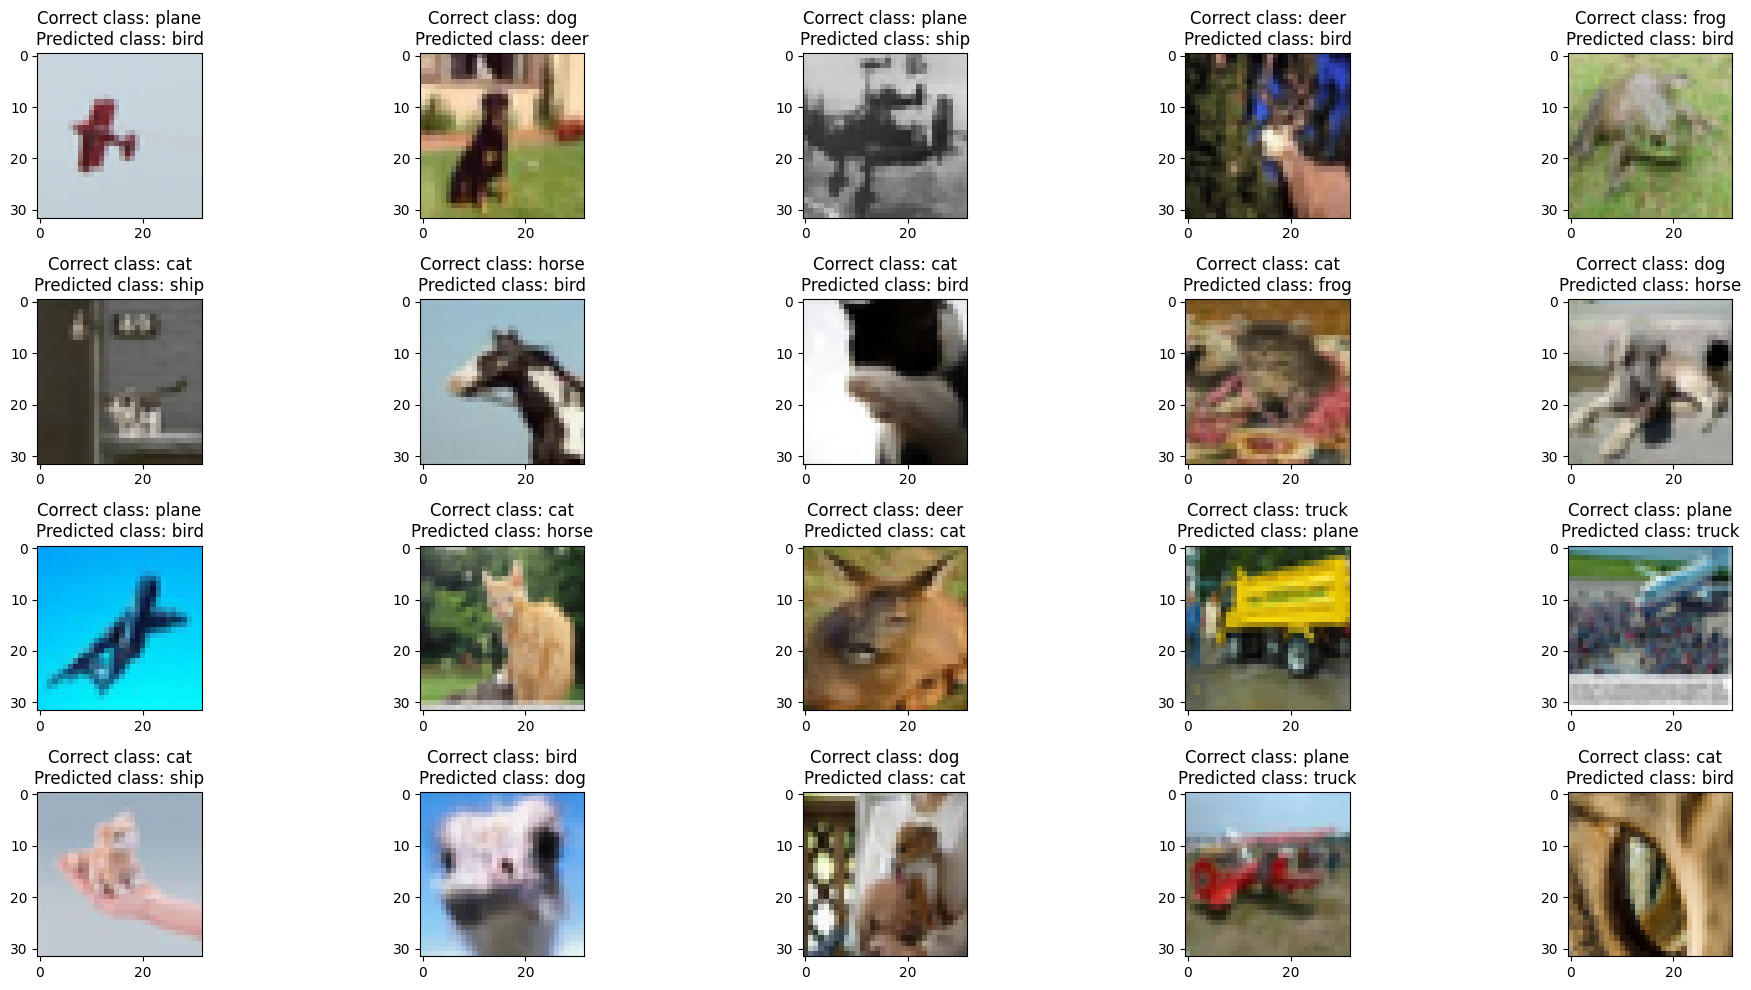

In [10]:
show_misclassified_images(
    misclassified_images[:20],
    predictions[:20],
    labels[:20],
    [
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ],
);


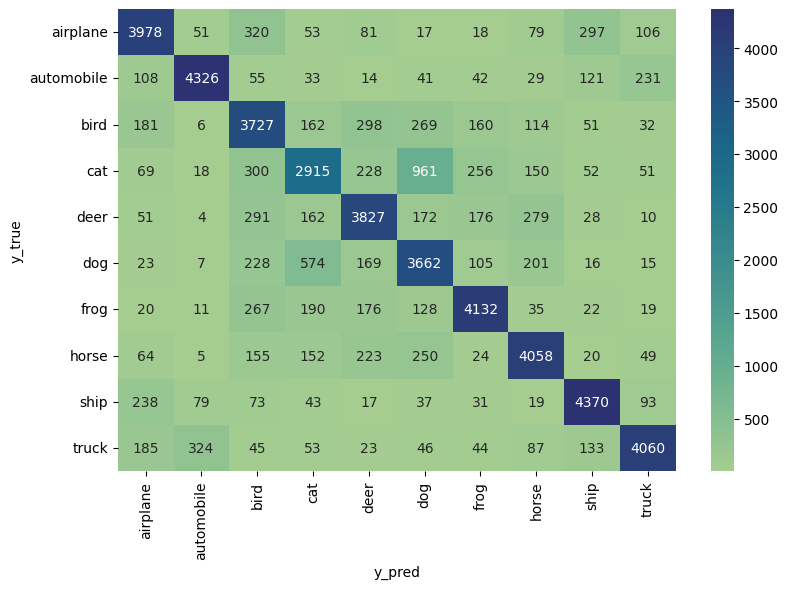

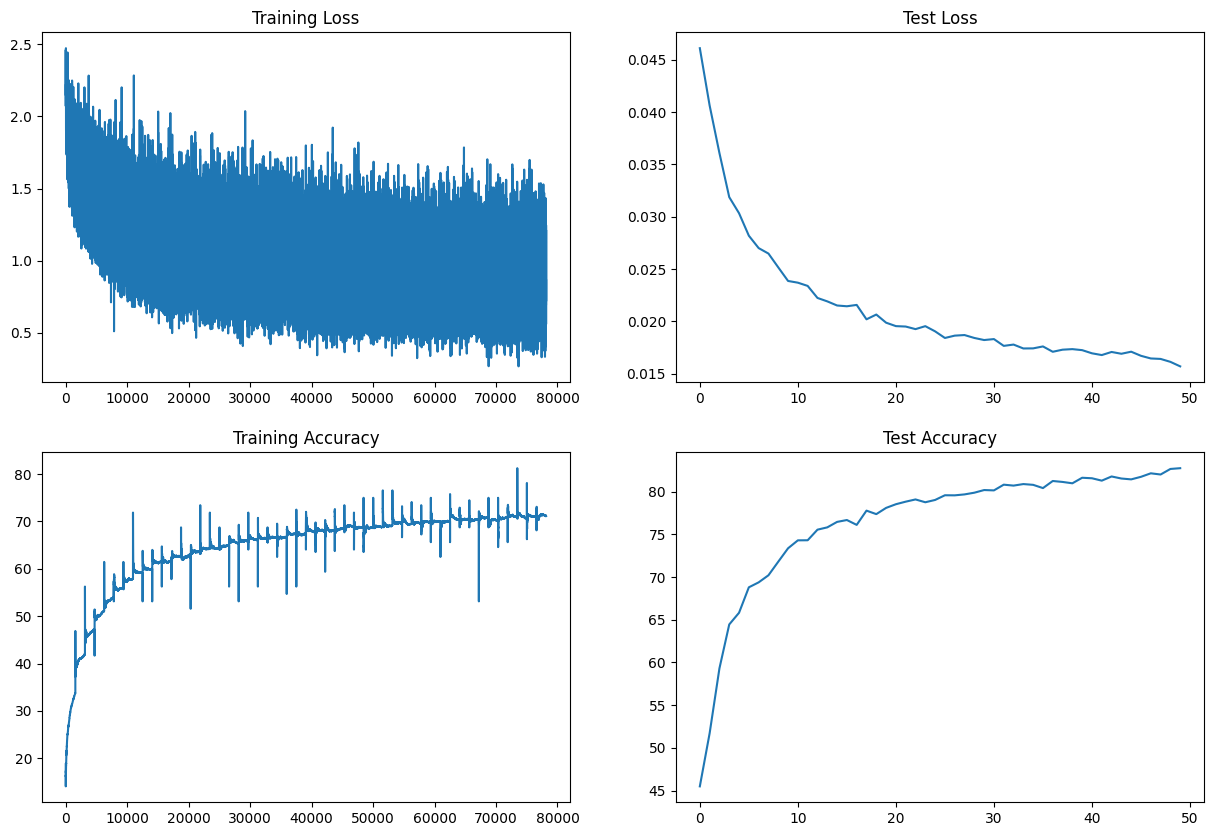

In [11]:
plot_confusion_matrix(model,train_loader,'cuda',train_loader.dataset.classes);
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies);

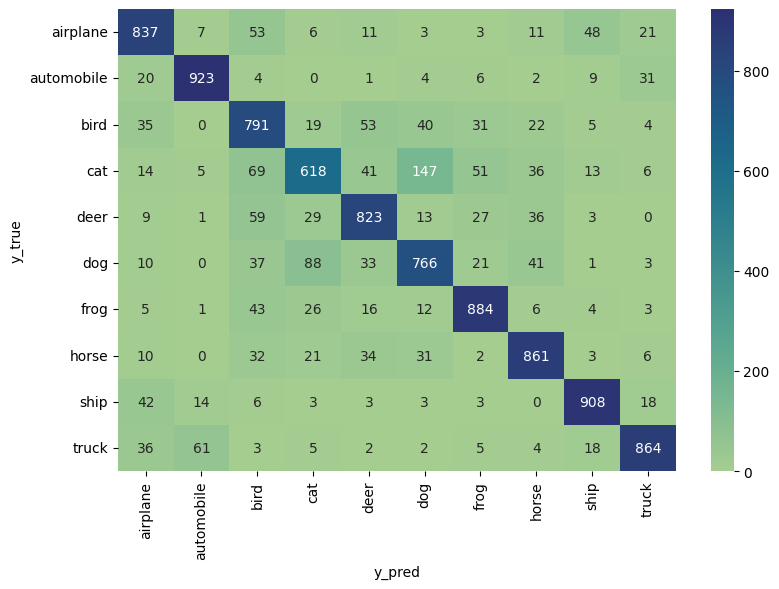

In [12]:
plot_confusion_matrix(model,test_loader,'cuda',test_loader.dataset.classes);